In [1]:
!pip install -q torch torchvision matplotlib
!pip install -q thop torchsummary

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

from common import *

In [3]:
# Create SummaryWriter
# writer = SummaryWriter("../tensorboard")

In [4]:
# Hyperparameters
BATCH_SIZE = 128
EPOCH = 80
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [5]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.4907277  0.48154452 0.44603667] [0.24783434 0.24407786 0.26223877]
[0.4907277  0.48154452 0.44603667] [0.24783434 0.24407786 0.26223877]


In [6]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),

    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [7]:
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader, valloader, testloader = get_cifar10_loaders(BATCH_SIZE, transform_train, transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


# Task 1
1. 搭建由{CNN,BN,ReLU}所組成的layer
2. 用兩層layer搭配pooling layer 和 FC layer創建出model
3. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = self.make_layer(3, 32)    # 3*32*32 -> 32*16*16
        self.layer2 = self.make_layer(32, 64)   # 32*16*16 -> 64*8*8
        self.layer3 = self.make_layer(64, 128)  # 64*8*8 -> 128*4*4
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(128*4*4, 10)

    def make_layer(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.fc(x.flatten(1))
        return x

model = SimpleCNN().train().to(DEVICE)
model

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [9]:
show_model_info(model, input_size=(3, 32, 32))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 10571776.0
Params: 114186.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5         

In [10]:
##### Train model #####
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model_path = f'./task1/simplecnn_{BATCH_SIZE}.pt'

train_loss, train_acc, val_loss, val_acc = train(
    model,
    trainloader,
    valloader,
    epochs=EPOCH,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path=best_model_path,
    early_stop_patience=10,
    existed='overwrite',
    device=DEVICE,
)

Epoch 1/80 (lr=1.0e-03), train_loss: 1.661, val_loss: 1.475, train_acc: 0.398, val_acc: 0.482
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task1/simplecnn_128.pt (0.466937 MB)
Epoch 2/80 (lr=1.0e-03), train_loss: 1.338, val_loss: 1.244, train_acc: 0.517, val_acc: 0.550
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task1/simplecnn_128.pt (0.466937 MB)
Epoch 3/80 (lr=1.0e-03), train_loss: 1.203, val_loss: 1.132, train_acc: 0.571, val_acc: 0.593
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task1/simplecnn_128.pt (0.466937 MB)
Epoch 4/80 (lr=1.0e-03), train_loss: 1.126, val_loss: 1.089, train_acc: 0.600, val_acc: 0.611
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task1/simplecnn_128.pt (0.466937 MB)
Epoch 5/80 (lr=1.0e-03), train_loss: 1.072, val_loss: 1.030, train_acc: 0.620, val_acc: 0.636
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/task1/simplecnn_128.pt (0.466937 MB)
Epoch 6/80 (lr=1.0e-03), train_loss: 1.033, val_lo

In [11]:
def load_model(model, filename: str, verbose: bool = True) -> None:
    state = torch.load(filename)
    if "total_ops" in state:
        state.pop("total_ops")
    if "total_params" in state:
        state.pop("total_params")
    model.load_state_dict(state)
    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")

In [12]:
model = SimpleCNN().cuda()
load_model(model, best_model_path)
test_loss, test_acc = evaluate(model, testloader, criterion, device=DEVICE)
print(f'Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}')

Model loaded from ./task1/simplecnn_128.pt (0.466937 MB)


/tmp/ipykernel_2817027/720588758.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


Test loss: 0.533, Test accuracy: 0.817


Plot saved at /home/master_112/nn6124030/eai2024/lab/lab2/task1/loss_accuracy-1.png


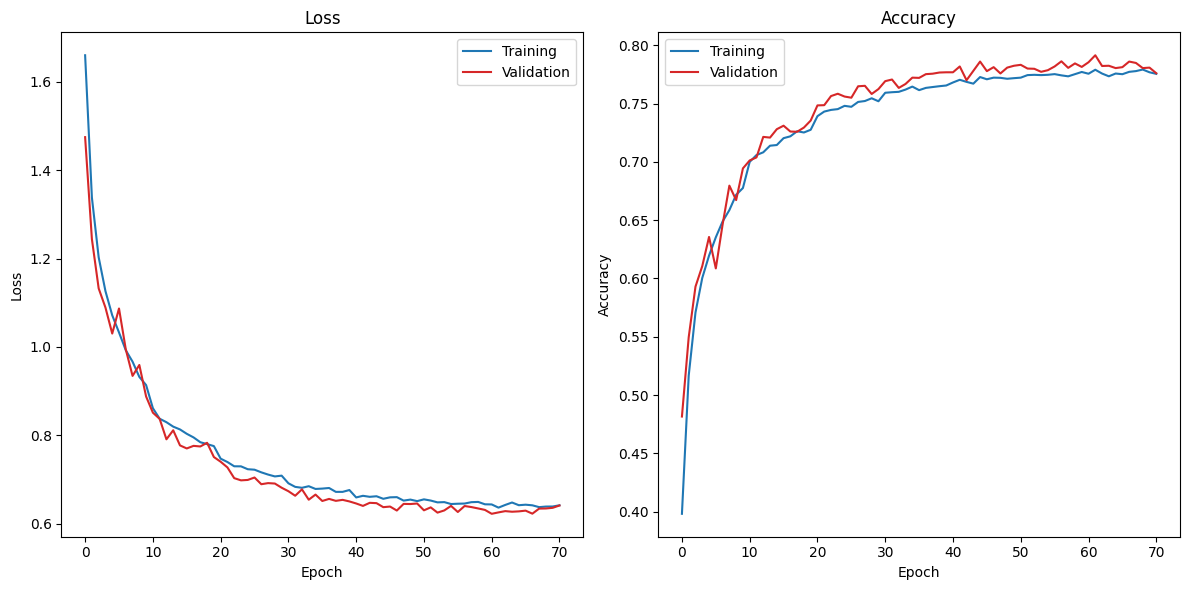

In [13]:
##### 繪製 loss 和 accuracy 的圖 #####
plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename="./task1/loss_accuracy.png")